In [1]:
import pandas as pd
import numpy as np
import pickle
import glob

In [2]:
journey_cols = [
    'timestamp', 
    'event', 
    'vehicle_id', 
    'line', 
    'longitude', 
    'latitude', 
    'direction', 
    'speed', 
    'station',
    'journey_number',
    'segment_number'
]

df = pd.DataFrame(columns=journey_cols).astype(dtype={
    'timestamp': 'object', 
    'event': 'object',
    'vehicle_id': 'int64',
    'line': 'int64',
    'longitude': 'float64', 
    'latitude': 'float64',
    'direction': 'float64',
    'speed': 'float64',
    'station': 'object',
    'journey_number': 'int64',
    'segment_number': 'int64'
})

In [3]:
for f in sorted(glob.glob('/home/max/det-ar-lugnt/buslines/*')):
    df = df.append(pickle.load(open(f, 'rb'))).astype(dtype={
        'timestamp': 'object', 
        'event': 'object',
        'vehicle_id': 'int64',
        'line': 'int64',
        'longitude': 'float64', 
        'latitude': 'float64',
        'direction': 'float64',
        'speed': 'float64',
        'station': 'object',
        'journey_number': 'int64',
        'segment_number': 'int64'
    })

Check number of rows:

In [4]:
len(df.index)

1567119

Check number of journeys:

In [13]:
df['journey_number'].max()

1477

Check max number of segments (should be correct number for the journey):

In [5]:
df['segment_number'].max()

12

Does some journeys have a fewer than this number of segments?

In [9]:
grouped = df.groupby('journey_number').max().reset_index()
max_segments = df['segment_number'].max()

In [10]:
len(grouped[grouped['segment_number'] < max_segments]['journey_number'])

86

These we can drop.

In [14]:
num_bad_journeys = len(grouped[grouped['segment_number'] < max_segments]['journey_number'])
print('The bad data makes up ~{:.2f}%'.format(100 * num_bad_journeys / df['journey_number'].nunique()))

The bad data makes up ~5.82%


Lets drop the rows where the journey has a fewer than the correct number of segments.

In [15]:
bad_journeys = grouped[grouped['segment_number'] < max_segments]['journey_number']

In [16]:
# sanity check
print('The good data that would be kept after dropping make up {:.2f}%'.format(
    100 * len(df[~df['journey_number'].isin(bad_journeys)].index) / len(df.index)))

The good data that would be kept after dropping make up 94.68%


In [17]:
df = df[~df['journey_number'].isin(bad_journeys)]

Which unique stations do we have? To confirm that the correct stations are in there, we have to check manually against the timetable for the line at www.ostgotatrafiken.se.  

In [18]:
_ = [print(s) for s in df['station'].unique()]

None
Link\xf6pings resecentrum
Kungsgatan
Tr\xe4dg\xe5rdstorget
Drottningtorget
Loftgatan
Tegelbruksgatan
Sandg\xe5rdsgatan
Stationsgatan
\xd6deg\xe5rdsgatan 11
\xd6deg\xe5rdsgatan 24
Johannelunds centrum
Tenndosan
\xd6vre Johannelund


In [24]:
print('Number of unique stations: {}'.format(df['station'].nunique(dropna=False)))

Number of unique stations: 14


In [27]:
# set the correct number of stations here, including the "None" station, here!
num_stations = 14

Do we have the same number of unique stations for every journey?

Note: we set `dropna=False` to also count the stations marked `None` due to missing station data in some events, such as the *ObservedPositionEvent*

In [25]:
grouped = df.groupby('journey_number')['station'].nunique(dropna=False)

In [26]:
grouped.unique()

array([14, 13])

If there are some stations that has less or more than the correct number of stations, we drop those.

In [28]:
grouped[grouped.apply(lambda x: x != num_stations)]

journey_number
44      13
122     13
265     13
318     13
325     13
334     13
338     13
372     13
429     13
431     13
482     13
523     13
539     13
595     13
692     13
758     13
788     13
828     13
859     13
987     13
1131    13
1241    13
1257    13
1286    13
1287    13
1300    13
1302    13
1307    13
1373    13
1412    13
Name: station, dtype: int64

Journeys above have an incorrect number of stations.

In [29]:
bad_journeys = [x for x in grouped[grouped.apply(lambda x: x != num_stations)].index]

We can check what happend in these journeys to make them have fewer unique stations..

In [31]:
print_count = 2 # increase this var to print more journeys
for journey in bad_journeys[:print_count]:
    print(f'journey: {journey}')
    _= [print(s) for s in df[df['journey_number'] == journey]['station'].unique()]
    print('\n')

journey: 44
None
Kungsgatan
Tr\xe4dg\xe5rdstorget
Drottningtorget
Loftgatan
Tegelbruksgatan
Sandg\xe5rdsgatan
Stationsgatan
\xd6deg\xe5rdsgatan 11
\xd6deg\xe5rdsgatan 24
Johannelunds centrum
Tenndosan
\xd6vre Johannelund


journey: 122
None
Kungsgatan
Tr\xe4dg\xe5rdstorget
Drottningtorget
Loftgatan
Tegelbruksgatan
Sandg\xe5rdsgatan
Stationsgatan
\xd6deg\xe5rdsgatan 11
\xd6deg\xe5rdsgatan 24
Johannelunds centrum
Tenndosan
\xd6vre Johannelund




So far the reason we have observed for having fewer stations is that the JourneyStartedEvent doesn't fire until the second station.

In [32]:
df = df[~df['journey_number'].isin(bad_journeys)]

In [33]:
print('We are left with {} journeys, comprising {} rows'.format(len(df['journey_number'].unique()), len(df.index)))

We are left with 1361 journeys, comprising 1453310 rows


### Plot and investigate erroneous driving

Code below does not generalize for any bus lines journey. Here you have to manually check if some journeys had a bus driver that took a wrong turn. 

In [122]:
#df.to_csv('bus203_all.csv')

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

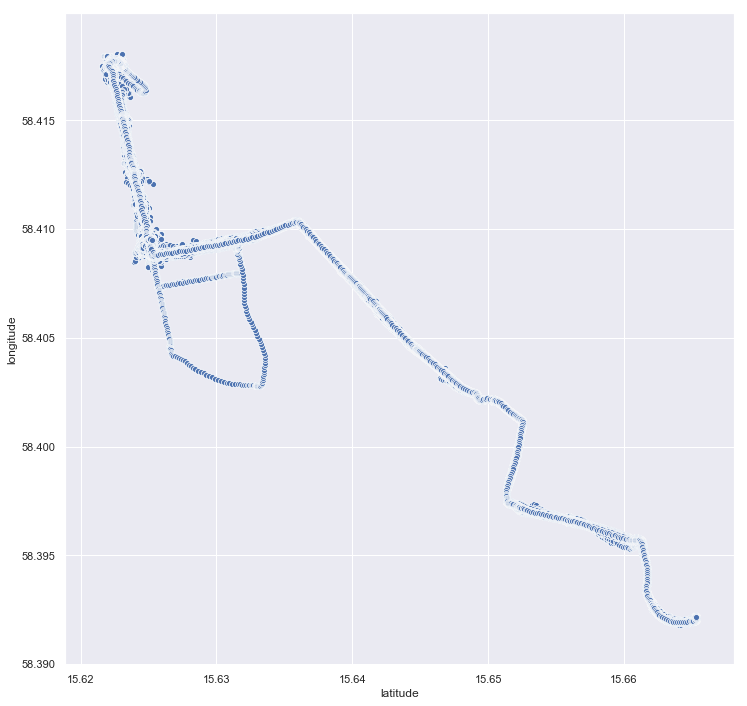

In [35]:
fig, ax = plt.subplots(1, figsize=(12,12))
sns.scatterplot(df['latitude'], df['longitude'], ax=ax)
plt.show()

In [37]:
df[(df['latitude'] < 15.63) & (df['longitude'] < 58.405)]['journey_number'].unique()

array([1343])

In [45]:
df[(df['latitude'] < 15.63) & (df['longitude'] < 58.4074)]['journey_number'].unique()

array([  10,   65,  150,  381,  809, 1150, 1338, 1343])

In [53]:
bad_driving = df[(df['latitude'] < 15.63) & (df['longitude'] < 58.4074)]['journey_number'].unique()

In [54]:
df2 = df[~df['journey_number'].isin(bad_driving)]

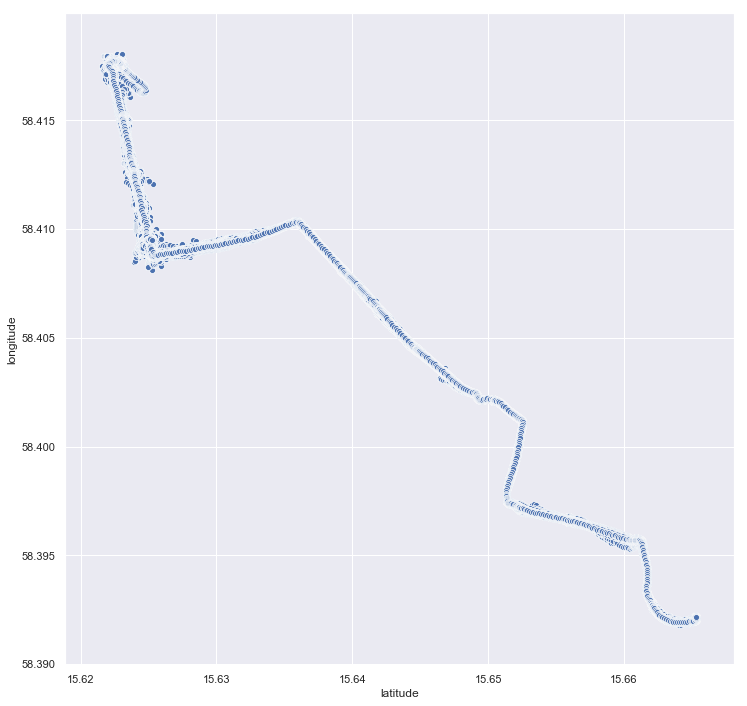

In [55]:
fig, ax = plt.subplots(1, figsize=(12,12))
sns.scatterplot(df2['latitude'], df2['longitude'], ax=ax)
plt.show()

In [56]:
len(df2.index)

1443808

In [74]:
len(df2['journey_number'].unique())

1353

In [57]:
df2.to_csv('bus211_all.csv')

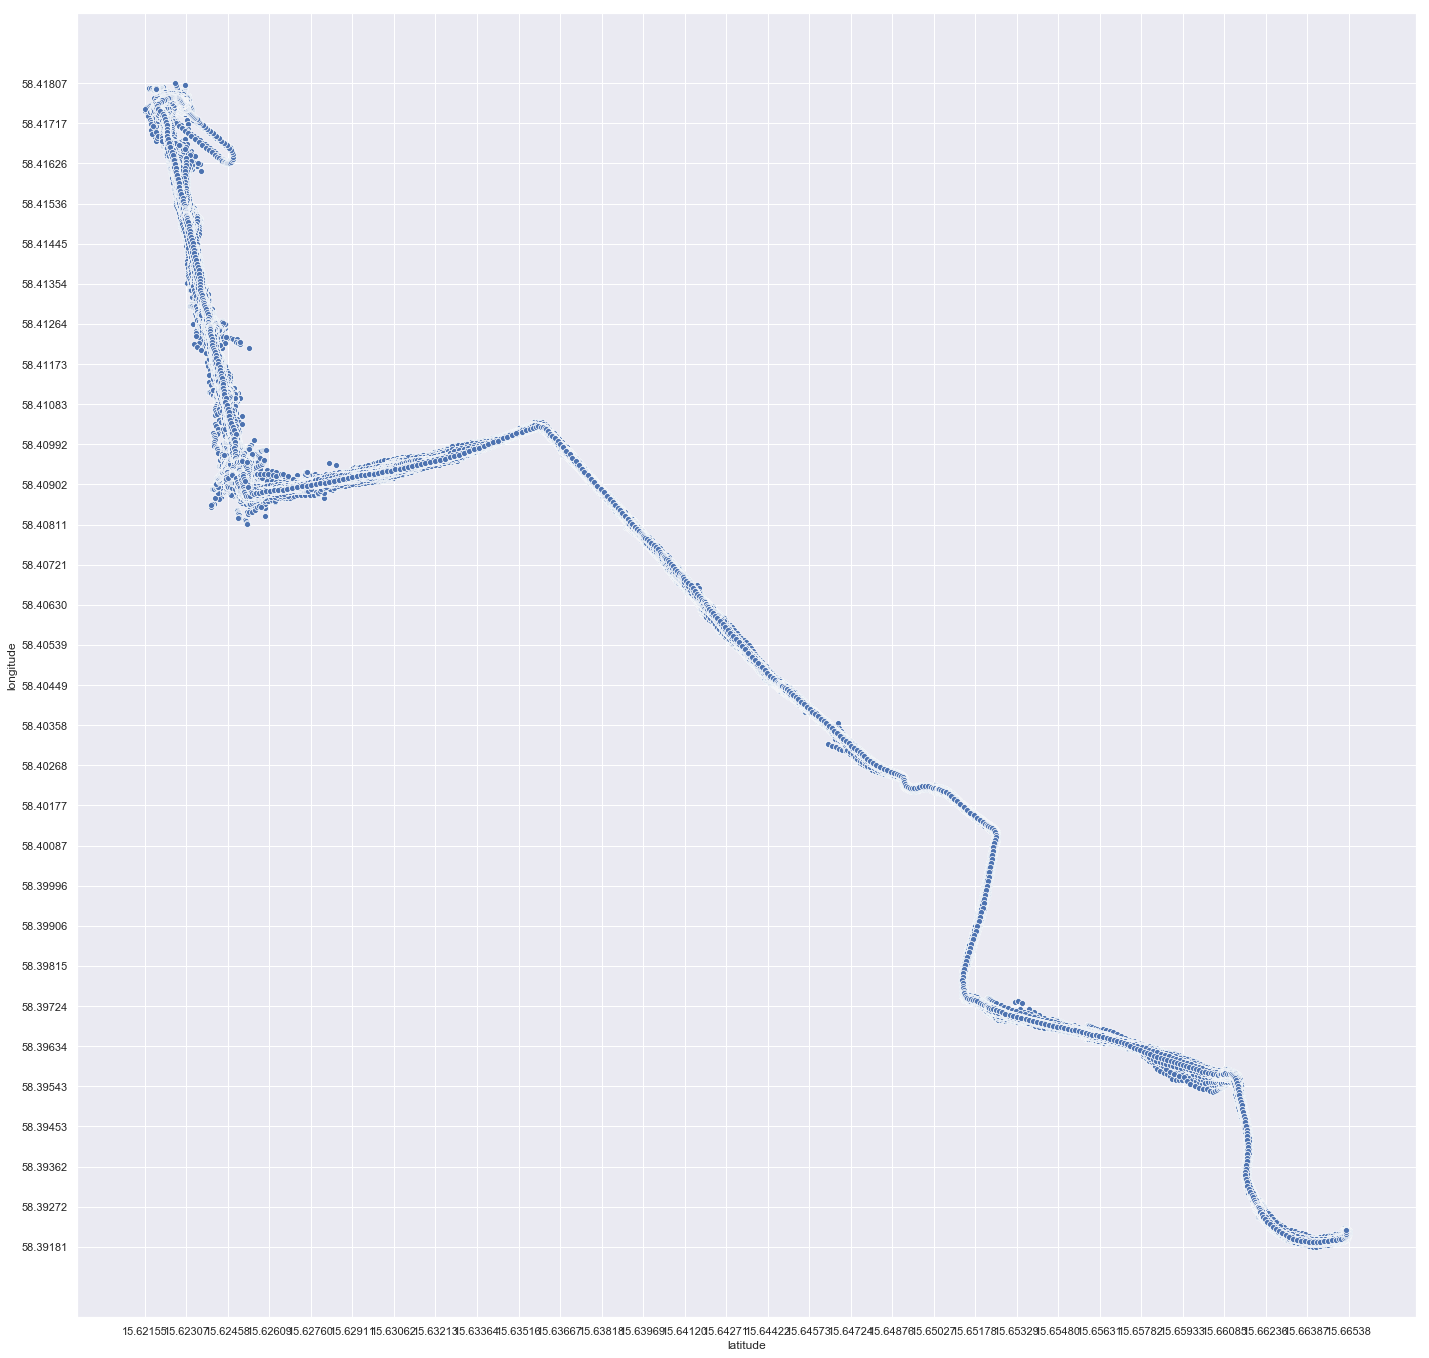

In [58]:
fig, ax = plt.subplots(1, figsize=(24,24))
sns.scatterplot(df2['latitude'], df2['longitude'], ax=ax)
ax.set_xticks(np.linspace(df2['latitude'].min(), df2['latitude'].max(), 30))
ax.set_yticks(np.linspace(df2['longitude'].min(), df2['longitude'].max(), 30))
plt.show()

In [70]:
df2[(df2['latitude'] > 15.62458) & 
   (df2['longitude'] < 58.41264) &
   (df2 ['longitude'] > 58.41173)]['journey_number'].unique()

array([1258])

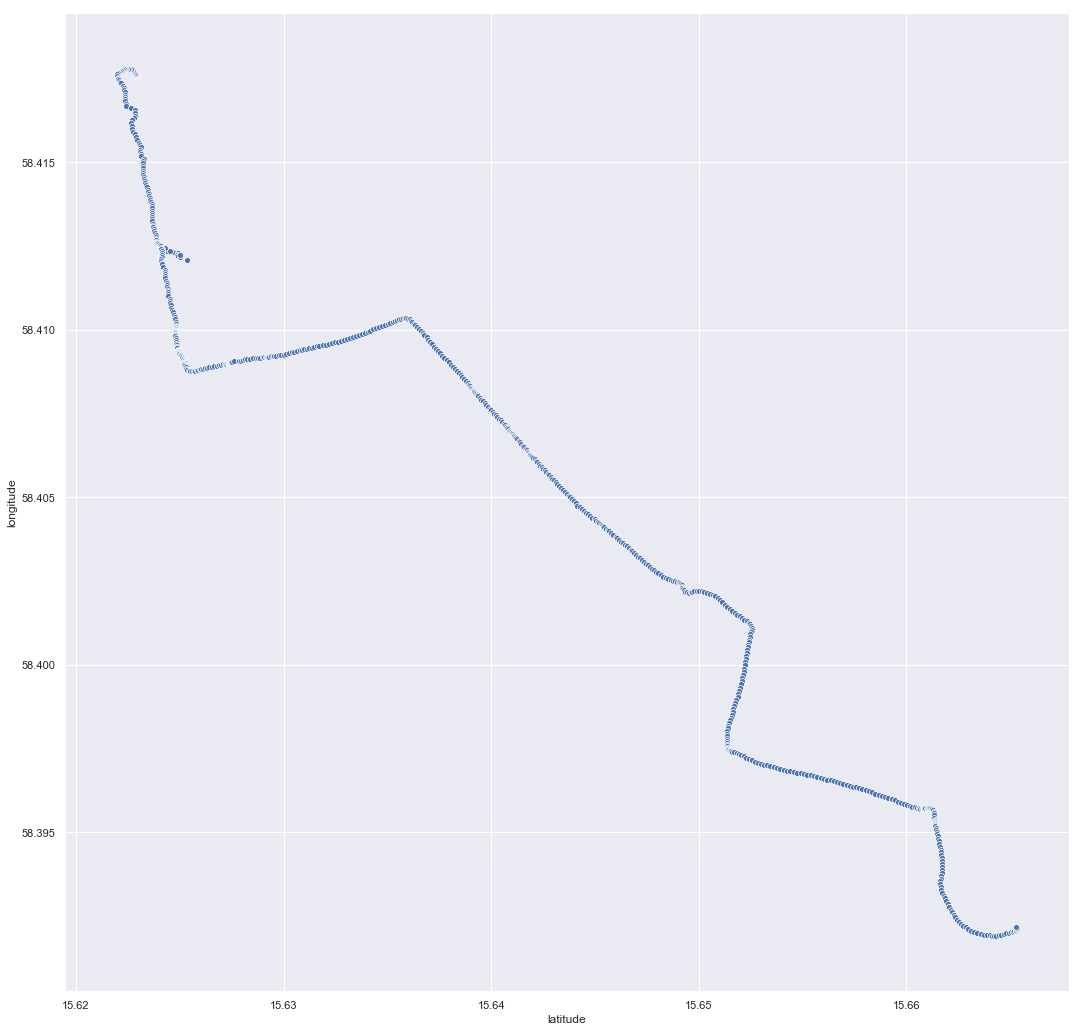

In [73]:
fig, ax = plt.subplots(1, figsize=(18,18))
sns.scatterplot(df[df['journey_number'] == 1258]['latitude'], df[df['journey_number'] == 1258]['longitude'], ax=ax)
plt.show()

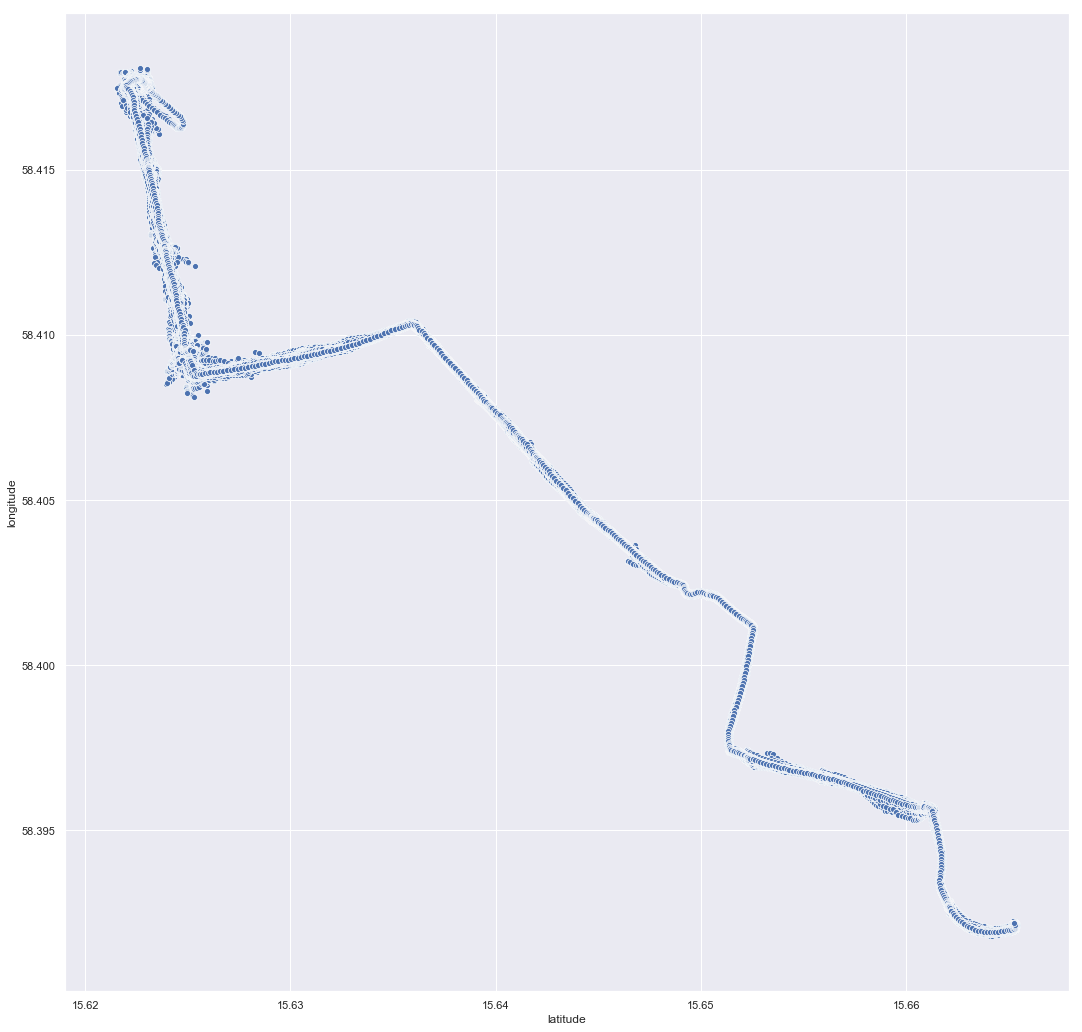

In [75]:
fig, ax = plt.subplots(1, figsize=(18,18))
sns.scatterplot(df2['latitude'], df2['longitude'], ax=ax)
plt.show()

In [79]:
df2.timestamp.max()

'2018-04-18T23:18:38.0000000+02:00'